In [1]:
import os
import sys

sys.path.append(os.path.join(os.path.abspath(".."), "code"))

import IPython
import matplotlib.pyplot as plt
import mglearn
import numpy as np
import pandas as pd
from IPython.display import HTML, display
from plotting_functions import *
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, cross_validate, train_test_split
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler
from utils import *

%matplotlib inline
pd.set_option("display.max_colwidth", 200)

from IPython.display import Image

# Lecture 9: Classification Metrics

UBC 2023-24

Instructor: Varada Kolhatkar and Andrew Roth

### Announcements

- HW4 is released.
- Please make use of OH and tutorials to interact with the teaching team and ask your questions.  
- Midterm is coming up soon (Oct 26th).

### Learning outcomes 

From this lecture, students are expected to be able to:

- Explain why accuracy is not always the best metric in ML.
- Explain components of a confusion matrix. 
- Define precision, recall, and f1-score and use them to evaluate different classifiers. 
- Broadly explain macro-average, weighted average.
- Interpret and use precision-recall curves. 
- Explain average precision score.
- Interpret and use ROC curves and ROC AUC using `scikit-learn`.  
- Identify whether there is class imbalance and whether you need to deal with it.
- Explain and use `class_weight` to deal with data imbalance.

### Dataset for demonstration 

Let's classify fraudulent and non-fraudulent transactions using Kaggle's [Credit Card Fraud Detection](https://www.kaggle.com/mlg-ulb/creditcardfraud) data set.

In [2]:
cc_df = pd.read_csv("../data/creditcard.csv", encoding="latin-1")
train_df, test_df = train_test_split(cc_df, test_size=0.3, random_state=111)
train_df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
64454,51150.0,-3.538816,3.481893,-1.827130,-0.573050,2.644106,-0.340988,2.102135,-2.939006,2.578654,...,0.530978,-0.860677,-0.201810,-1.719747,0.729143,-0.547993,-0.023636,-0.454966,1.00,0
37906,39163.0,-0.363913,0.853399,1.648195,1.118934,0.100882,0.423852,0.472790,-0.972440,0.033833,...,0.687055,-0.094586,0.121531,0.146830,-0.944092,-0.558564,-0.186814,-0.257103,18.49,0
79378,57994.0,1.193021,-0.136714,0.622612,0.780864,-0.823511,-0.706444,-0.206073,-0.016918,0.781531,...,-0.310405,-0.842028,0.085477,0.366005,0.254443,0.290002,-0.036764,0.015039,23.74,0
245686,152859.0,1.604032,-0.808208,-1.594982,0.200475,0.502985,0.832370,-0.034071,0.234040,0.550616,...,0.519029,1.429217,-0.139322,-1.293663,0.037785,0.061206,0.005387,-0.057296,156.52,0
60943,49575.0,-2.669614,-2.734385,0.662450,-0.059077,3.346850,-2.549682,-1.430571,-0.118450,0.469383,...,-0.228329,-0.370643,-0.211544,-0.300837,-1.174590,0.573818,0.388023,0.161782,57.50,0


In [3]:
train_df.shape

(199364, 31)

### EDA

In [4]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 199364 entries, 64454 to 129900
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    199364 non-null  float64
 1   V1      199364 non-null  float64
 2   V2      199364 non-null  float64
 3   V3      199364 non-null  float64
 4   V4      199364 non-null  float64
 5   V5      199364 non-null  float64
 6   V6      199364 non-null  float64
 7   V7      199364 non-null  float64
 8   V8      199364 non-null  float64
 9   V9      199364 non-null  float64
 10  V10     199364 non-null  float64
 11  V11     199364 non-null  float64
 12  V12     199364 non-null  float64
 13  V13     199364 non-null  float64
 14  V14     199364 non-null  float64
 15  V15     199364 non-null  float64
 16  V16     199364 non-null  float64
 17  V17     199364 non-null  float64
 18  V18     199364 non-null  float64
 19  V19     199364 non-null  float64
 20  V20     199364 non-null  float64
 21  V21     199

In [5]:
train_df.describe(include="all")

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,199364.000000,199364.000000,199364.000000,199364.000000,199364.000000,199364.000000,199364.000000,199364.000000,199364.000000,199364.000000,...,199364.000000,199364.000000,199364.000000,199364.000000,199364.000000,199364.000000,199364.000000,199364.000000,199364.000000,199364.000000
mean,94888.815669,0.000492,-0.000726,0.000927,0.000630,0.000036,0.000011,-0.001286,-0.002889,-0.000891,...,0.001205,0.000155,-0.000198,0.000113,0.000235,0.000312,-0.000366,0.000227,88.164679,0.001700
std,47491.435489,1.959870,1.645519,1.505335,1.413958,1.361718,1.327188,1.210001,1.214852,1.096927,...,0.748510,0.726634,0.628139,0.605060,0.520857,0.481960,0.401541,0.333139,238.925768,0.041201
min,0.000000,-56.407510,-72.715728,-31.813586,-5.683171,-42.147898,-26.160506,-43.557242,-73.216718,-13.320155,...,-34.830382,-8.887017,-44.807735,-2.824849,-10.295397,-2.241620,-22.565679,-11.710896,0.000000,0.000000
25%,54240.000000,-0.918124,-0.600193,-0.892476,-0.847178,-0.691241,-0.768512,-0.553979,-0.209746,-0.642965,...,-0.227836,-0.541795,-0.162330,-0.354604,-0.317761,-0.326730,-0.070929,-0.052819,5.640000,0.000000
50%,84772.500000,0.018854,0.065463,0.179080,-0.019531,-0.056703,-0.275290,0.040497,0.022039,-0.052607,...,-0.029146,0.007666,-0.011678,0.041031,0.016587,-0.052790,0.001239,0.011234,22.000000,0.000000
75%,139349.250000,1.315630,0.803617,1.028023,0.744201,0.610407,0.399827,0.570449,0.327408,0.597326,...,0.186899,0.529210,0.146809,0.439209,0.351366,0.242169,0.090453,0.078052,77.150000,0.000000
max,172792.000000,2.451888,22.057729,9.382558,16.491217,34.801666,23.917837,44.054461,19.587773,15.594995,...,27.202839,10.503090,22.083545,4.022866,6.070850,3.517346,12.152401,33.847808,11898.090000,1.000000


- It's easier to demonstrate evaluation metrics using an explicit validation set instead of using cross-validation. 
- So let's create a validation set. 
- Our data is large enough so it shouldn't be a problem. 

In [6]:
X_train_big, y_train_big = train_df.drop(columns=["Class", "Time"]), train_df["Class"]
X_test, y_test = test_df.drop(columns=["Class", "Time"]), test_df["Class"]
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_big, y_train_big, test_size=0.3, random_state=123
)

### Baseline

In [7]:
dummy = DummyClassifier()
pd.DataFrame(cross_validate(dummy, X_train, y_train, return_train_score=True)).mean()

fit_time       0.012197
score_time     0.002049
test_score     0.998302
train_score    0.998302
dtype: float64

In [8]:
train_df["Class"].value_counts(normalize=True)

Class
0    0.9983
1    0.0017
Name: proportion, dtype: float64

### `LogisticRegression`

In [9]:
pipe = make_pipeline(StandardScaler(), LogisticRegression())
pd.DataFrame(cross_validate(pipe, X_train, y_train, return_train_score=True)).mean()

fit_time       0.587211
score_time     0.010523
test_score     0.999176
train_score    0.999235
dtype: float64

- `.score` by default returns accuracy which is 
$$\frac{\text{correct predictions}}{\text{total examples}}$$

- Is accuracy a good metric here? 

- Is there anything more informative than accuracy that we can use here? 

## Confusion matrix

- False positives (type I errors), where the model incorrectly spots examples as fraud
- False negatives (type II errors), where it's missing to spot fraud examples 

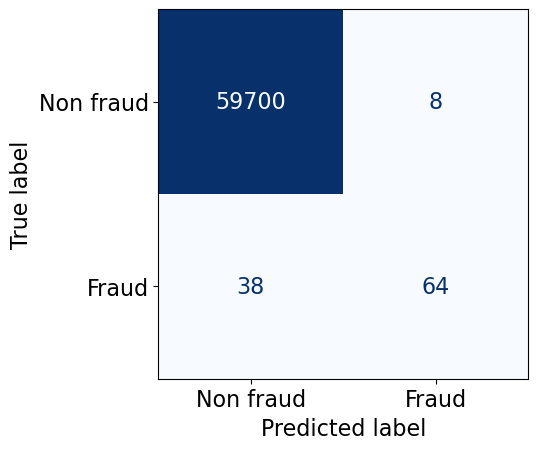

In [10]:
from sklearn.metrics import ConfusionMatrixDisplay

pipe.fit(X_train, y_train)
disp = ConfusionMatrixDisplay.from_estimator(
    pipe,
    X_valid,
    y_valid,
    display_labels=["Non fraud", "Fraud"],
    values_format="d",
    cmap=plt.cm.Blues,
    colorbar=False,
);

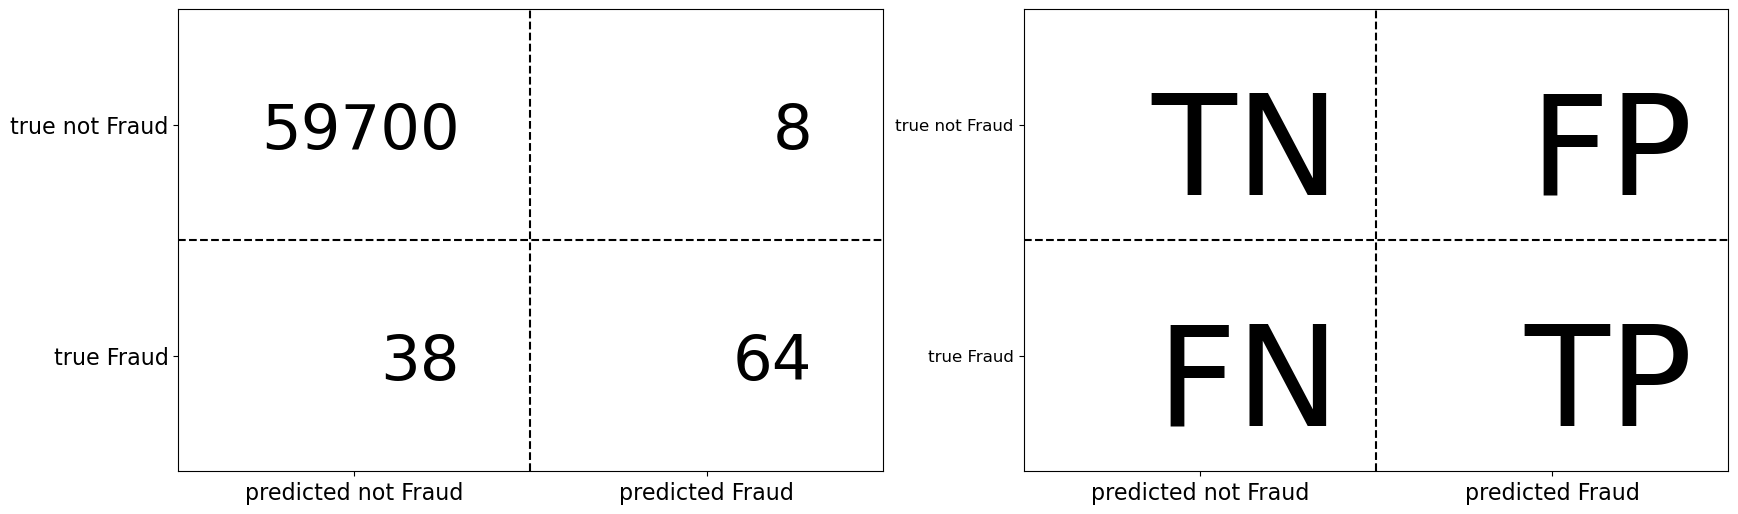

In [11]:
from sklearn.metrics import confusion_matrix

predictions = pipe.predict(X_valid)
TN, FP, FN, TP = confusion_matrix(y_valid, predictions).ravel()
plot_confusion_matrix_example(TN, FP, FN, TP)

- Perfect prediction has all values down the diagonal
- Off diagonal entries can often tell us about what is being mis-predicted

### What is "positive" and "negative"?

- Two kinds of binary classification problems 
    - Distinguishing between two classes
    - Spotting a class (spot fraud transaction, spot spam, spot disease)

- In case of spotting problems, the thing that we are interested in spotting is considered "positive". 

- Above we wanted to spot fraudulent transactions and so they are "positive". 

### Confusion matrix with cross-validation 

- You can also calculate confusion matrix with cross-validation using the `cross_val_predict` method.  
- But then you cannot conveniently use `plot_confusion_matrix`. 

In [12]:
from sklearn.model_selection import cross_val_predict

confusion_matrix(y_train, cross_val_predict(pipe, X_train, y_train))

array([[139296,     21],
       [    94,    143]])

### Precision, Recall, F1 score 

- We have been using `.score` to assess our models, which returns accuracy by default. 
- Accuracy is misleading when we have class imbalance.
- We need other metrics to assess our models.

- We'll discuss three commonly used metrics which are based on confusion matrix: 
    - Recall
    - Precision
    - F1 score 
- Note that these metrics will only help us assessing our model.  
- Later we'll talk about a few ways to address class imbalance problem. 

### Precision and recall: toy example
- Imagine that your model has identified everything outside the circle as non-fraud and everything inside the circle as fraud. 

<!-- <img src="../img/fraud-precision-recall.png" height="600" width="600">  -->
![](../img/fraud-precision-recall.png)

In [13]:
from sklearn.metrics import confusion_matrix

pipe_lr = make_pipeline(StandardScaler(), LogisticRegression())
pipe_lr.fit(X_train, y_train)
predictions = pipe_lr.predict(X_valid)
TN, FP, FN, TP = confusion_matrix(y_valid, predictions).ravel()
print(disp.confusion_matrix)

[[59700     8]
 [   38    64]]


### Recall 

Among all positive examples, how many did you identify?
$$ recall = \frac{TP}{TP+FN} = \frac{TP}{\#positives} $$

In [14]:
print("TP = %0.4f, FN = %0.4f" % (TP, FN))
recall = TP / (TP + FN)
print("Recall: %0.4f" % (recall))

TP = 64.0000, FN = 38.0000
Recall: 0.6275


### Precision 

Among the positive examples you identified, how many were actually positive?

$$ precision = \frac{TP}{TP+FP}$$

In [15]:
print("TP = %0.4f, FP = %0.4f" % (TP, FP))
precision = TP / (TP + FP)
print("Precision: %0.4f" % (precision))

TP = 64.0000, FP = 8.0000
Precision: 0.8889


### F1-score

- F1-score combines precision and recall to give one score, which could be used in hyperparameter optimization, for instance. 
- F1-score is a harmonic mean of precision and recall. 


$$ F1 = 2 \times \frac{ precision \times recall}{precision + recall}$$


In [16]:
print("precision: %0.4f" % (precision))
print("recall: %0.4f" % (recall))
f1_score = (2 * precision * recall) / (precision + recall)
print("f1: %0.4f" % (f1_score))

precision: 0.8889
recall: 0.6275
f1: 0.7356


In [17]:
## Calculate evaluation metrics by ourselves
data = {
    "calculation": [],
    "accuracy": [],
    "error": [],
    "precision": [],
    "recall": [],
    "f1 score": [],
}
data["calculation"].append("manual")
data["accuracy"].append((TP + TN) / (TN + FP + FN + TP))
data["error"].append((FP + FN) / (TN + FP + FN + TP))
data["precision"].append(precision)  # TP / (TP + FP)
data["recall"].append(recall)  # TP / (TP + FN)
data["f1 score"].append(f1_score)  # (2 * precision * recall) / (precision + recall)
df = pd.DataFrame(data)
df

,calculation,accuracy,error,precision,recall,f1 score
0,manual,0.999231,0.000769,0.888889,0.627451,0.735632


In [18]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

data["accuracy"].append(accuracy_score(y_valid, pipe_lr.predict(X_valid)))
data["error"].append(1 - accuracy_score(y_valid, pipe_lr.predict(X_valid)))
data["precision"].append(
    precision_score(y_valid, pipe_lr.predict(X_valid), zero_division=1)
)
data["recall"].append(recall_score(y_valid, pipe_lr.predict(X_valid)))
data["f1 score"].append(f1_score(y_valid, pipe_lr.predict(X_valid)))
data["calculation"].append("sklearn")
df = pd.DataFrame(data)
df.set_index(["calculation"])

,accuracy,error,precision,recall,f1 score
calculation,,,,,
manual,0.999231,0.000769,0.888889,0.627451,0.735632
sklearn,0.999231,0.000769,0.888889,0.627451,0.735632


### Classification report 

In [19]:
pipe_lr.classes_

array([0, 1])

In [20]:
from sklearn.metrics import classification_report

print(
    classification_report(
        y_valid, pipe_lr.predict(X_valid), target_names=["non-fraud", "fraud"]
    )
)

              precision    recall  f1-score   support

   non-fraud       1.00      1.00      1.00     59708
       fraud       0.89      0.63      0.74       102

    accuracy                           1.00     59810
   macro avg       0.94      0.81      0.87     59810
weighted avg       1.00      1.00      1.00     59810



### Interim summary 

- Accuracy is misleading when you have class imbalance. 
- A confusion matrix provides a way to break down errors made by our model. 
- We looked at three metrics based on confusion matrix: 
    - Precision, Recall, F1-score. 

- Note that what you consider "positive" (fraud in our case) is important when calculating precision, recall, and F1-score. 
- If you flip what is considered positive or negative, we'll end up with different TP, FP, TN, FN, and hence different precision, recall, and F1-scores. 

![](../img/evaluation-metrics.png)
<!-- <img src='../img/evaluation-metrics.png' width="1000" height="1000" /> -->

### Cross validation with different metrics

In [21]:
scoring = [
    "accuracy",
    "f1",
    "recall",
    "precision",
]  # scoring can be a string, a list, or a dictionary
pipe = make_pipeline(StandardScaler(), LogisticRegression())
scores = cross_validate(
    pipe, X_train_big, y_train_big, return_train_score=True, scoring=scoring
)
pd.DataFrame(scores)

,fit_time,score_time,test_accuracy,train_accuracy,test_f1,train_f1,test_recall,train_recall,test_precision,train_precision
0,1.276776,0.102092,0.999097,0.999360,0.694915,0.782979,0.602941,0.678967,0.820000,0.924623
1,1.088233,0.093971,0.999223,0.999317,0.739496,0.766595,0.647059,0.660517,0.862745,0.913265
2,1.288138,0.104035,0.999273,0.999216,0.743363,0.726477,0.617647,0.612546,0.933333,0.892473
3,1.109370,0.236774,0.999172,0.999254,0.697248,0.742981,0.558824,0.634686,0.926829,0.895833
4,1.009844,0.092141,0.999147,0.999216,0.696429,0.728850,0.582090,0.617647,0.866667,0.888889


### (iClicker) Exercise 9.1 

**iClicker cloud join link: https://join.iclicker.com/SNBF**

**Select all of the following statements which are TRUE.**

- (A) In medical diagnosis, false positives are likely to be more damaging than false negatives (assume "positive" means the person has a disease, "negative" means they don't).
- (B) In spam classification, false positives are more damaging than false negatives (assume "positive" means the email is spam, "negative" means it's not).
- (C) If method A gets a higher accuracy than method B, that means its precision is also higher.
- (D) If method A gets a higher accuracy than method B, that means its recall is also higher.

### Precision-recall curve and ROC curve

- Confusion matrix provides a detailed break down of the errors made by the model. 
- But when creating a confusion matrix, we are using "hard" predictions. 
- Most classifiers in `scikit-learn` provide `predict_proba` method (or `decision_function`) which provides degree of certainty about predictions by the classifier. 
- Can we explore the degree of uncertainty to understand and improve the model performance? 

In [22]:
pipe_lr = make_pipeline(StandardScaler(), LogisticRegression())
pipe_lr.fit(X_train, y_train);

In [23]:
y_pred = pipe_lr.predict(X_valid)
print(classification_report(y_valid, y_pred, target_names=["non-fraud", "fraud"]))

              precision    recall  f1-score   support

   non-fraud       1.00      1.00      1.00     59708
       fraud       0.89      0.63      0.74       102

    accuracy                           1.00     59810
   macro avg       0.94      0.81      0.87     59810
weighted avg       1.00      1.00      1.00     59810



In [24]:
y_pred = pipe_lr.predict_proba(X_valid)[:, 1] > 0.50
print(classification_report(y_valid, y_pred, target_names=["non-fraud", "fraud"]))

              precision    recall  f1-score   support

   non-fraud       1.00      1.00      1.00     59708
       fraud       0.89      0.63      0.74       102

    accuracy                           1.00     59810
   macro avg       0.94      0.81      0.87     59810
weighted avg       1.00      1.00      1.00     59810



In [25]:
y_pred_lower_threshold = pipe_lr.predict_proba(X_valid)[:, 1] > 0.1
print(classification_report(y_valid, y_pred_lower_threshold, target_names=["non-fraud", "fraud"]))

              precision    recall  f1-score   support

   non-fraud       1.00      1.00      1.00     59708
       fraud       0.77      0.76      0.77       102

    accuracy                           1.00     59810
   macro avg       0.89      0.88      0.88     59810
weighted avg       1.00      1.00      1.00     59810



### Operating point 

- Now our recall for "fraud" class is >= 0.75. 
- Setting a requirement on a classifier (e.g., recall of >= 0.75) is called setting the **operating point**. 
- It's usually driven by business goals and is useful to make performance guarantees to customers. 

### Precision/Recall tradeoff 

- But there is a trade-off between precision and recall. 
- If you identify more things as "fraud", recall is going to increase but there are likely to be more false positives. 

In [26]:
pr_dict = {"threshold": [], "precision": [], "recall": [], "f1 score": []}
for threshold in np.arange(0.0, 1.0, 0.1):
    preds = pipe_lr.predict_proba(X_valid)[:, 1] > threshold
    pr_dict["threshold"].append(threshold)
    pr_dict["precision"].append(precision_score(y_valid, preds))
    pr_dict["recall"].append(recall_score(y_valid, preds))
    pr_dict["f1 score"].append(f1_score(y_valid, preds))
pd.DataFrame(pr_dict)

,threshold,precision,recall,f1 score
0,0.0,0.001705,1.000000,0.003405
1,0.1,0.772277,0.764706,0.768473
2,0.2,0.793478,0.715686,0.752577
3,0.3,0.814815,0.647059,0.721311
4,0.4,0.876712,0.627451,0.731429
5,0.5,0.888889,0.627451,0.735632
6,0.6,0.897059,0.598039,0.717647
7,0.7,0.893939,0.578431,0.702381
8,0.8,0.903226,0.549020,0.682927
9,0.9,0.892857,0.490196,0.632911


### Precision-recall curve

Often, when developing a model, it's not always clear what the operating point will be and to understand the the model better, it's informative to look at all possible thresholds and corresponding trade-offs of precision and recall in a plot.  


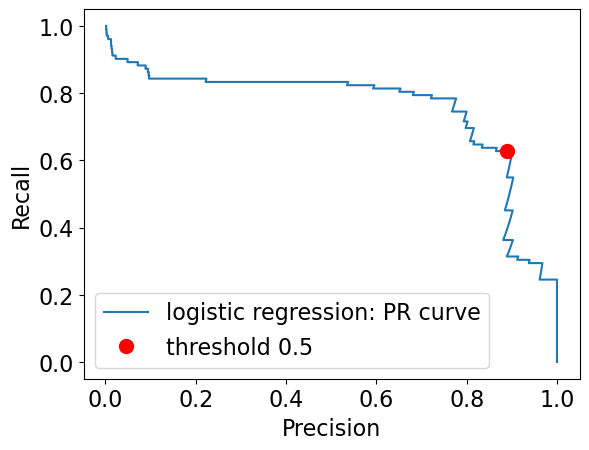

In [27]:
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds = precision_recall_curve(
    y_valid, pipe_lr.predict_proba(X_valid)[:, 1]
)
plt.plot(precision, recall, label="logistic regression: PR curve")
plt.xlabel("Precision")
plt.ylabel("Recall")
plt.plot(
    precision_score(y_valid, pipe_lr.predict(X_valid)),
    recall_score(y_valid, pipe_lr.predict(X_valid)),
    "or",
    markersize=10,
    label="threshold 0.5",
)
plt.legend(loc="best");

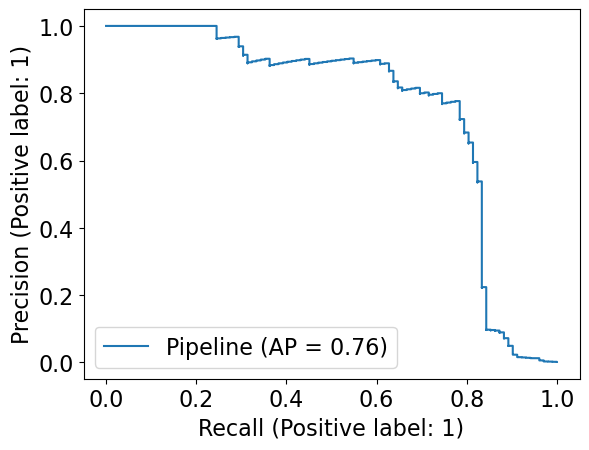

In [28]:
from sklearn.metrics import PrecisionRecallDisplay

PrecisionRecallDisplay.from_estimator(pipe_lr, X_valid, y_valid);

### A few comments on PR curve

- Different classifiers might work well in different parts of the curve, i.e., at different operating points.   
- We can compare PR curves of different classifiers to understand these differences. 

### AP score 

- Often it's useful to have one number summarizing the PR plot (e.g., in hyperparameter optimization)
- One way to do this is by computing the area under the PR curve. 
- This is called **average precision** (AP score)
- AP score has a value between 0 (worst) and 1 (best). 

In [29]:
from sklearn.metrics import average_precision_score

ap_lr = average_precision_score(y_valid, pipe_lr.predict_proba(X_valid)[:, 1])
print("Average precision of logistic regression: {:.3f}".format(ap_lr))

Average precision of logistic regression: 0.757


### AP vs. F1-score

It is very important to note this distinction:

- F1 score is for a given threshold and measures the quality of `predict`.

- AP score is a summary across thresholds and measures the quality of `predict_proba`.

### Receiver Operating Characteristic (ROC) curve 

- Another commonly used tool to analyze the behavior of classifiers at different thresholds.  
- Similar to PR curve, it considers all possible thresholds for a given classifier given by `predict_proba` but instead of precision and recall it plots false positive rate (FPR) and true positive rate (TPR or recall).
$$ TPR = \frac{TP}{TP + FN}, FPR  = \frac{FP}{FP + TN}$$


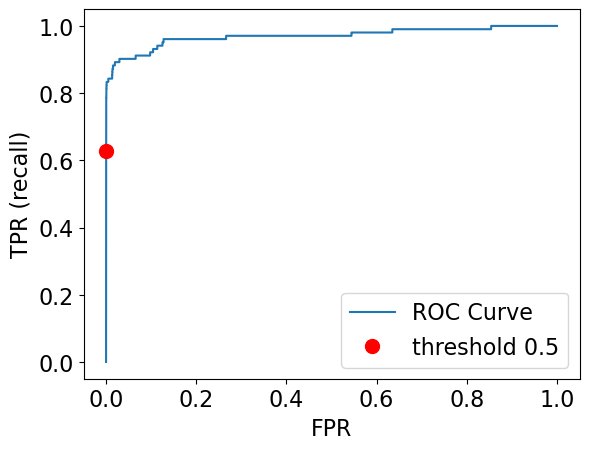

In [30]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_valid, pipe_lr.predict_proba(X_valid)[:, 1])
plt.plot(fpr, tpr, label="ROC Curve")
plt.xlabel("FPR")
plt.ylabel("TPR (recall)")

default_threshold = np.argmin(np.abs(thresholds - 0.5))

plt.plot(
    fpr[default_threshold],
    tpr[default_threshold],
    "or",
    markersize=10,
    label="threshold 0.5",
)
plt.legend(loc="best");

- The ideal curve is close to the top left
    - Ideally, you want a classifier with high recall while keeping low false positive rate.  
- The red dot corresponds to the threshold of 0.5, which is used by predict.
- We see that compared to the default threshold, we can achieve a better recall of around 0.8 without increasing FPR. 

### Area under the curve (AUC)

- AUC provides a single meaningful number for the model performance. 

In [31]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_valid, pipe_lr.predict_proba(X_valid)[:, 1])

0.9700376801085544

- AUC of 0.5 means random chance. 
- AUC can be interpreted as evaluating the **ranking** of positive examples.
- What's the probability that a randomly picked positive point has a higher score according to the classifier than a randomly picked point from the negative class. 
- AUC of 1.0 means all positive points have a higher score than all negative points. 

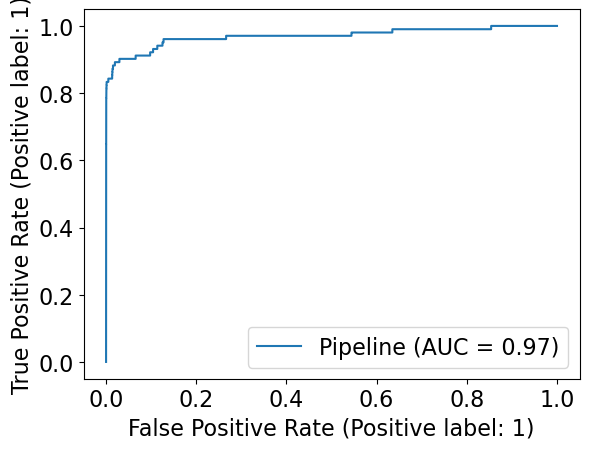

In [32]:
from sklearn.metrics import RocCurveDisplay

RocCurveDisplay.from_estimator(pipe_lr, X_valid, y_valid);

### Class imbalance in training sets

- This typically refers to having many more examples of one class than another in one's training set.
- Real world data is often imbalanced. 
    - Our Credit Card Fraud dataset is imbalanced.
    - Ad clicking data is usually drastically imbalanced. (Only around ~0.01% ads are clicked.)
    - Spam classification datasets are also usually imbalanced.

### Addressing class imbalance
A very important question to ask yourself: "Why do I have a class imbalance?"

- Is it because one class is much more rare than the other?
    - If it's just because one is more rare than the other, you need to ask whether you care about one type of error more than the other.    
- Is it because of my data collection methods?
    - If it's the data collection, then that means _your test and training data come from different distributions_!
  
In some cases, it may be fine to just ignore the class imbalance.

### Which type of error is more important? 

- False positives (FPs) and false negatives (FNs) have quite different real-world consequences. 
- In PR curve and ROC curve, we saw how changing the prediction threshold can change FPs and FNs. 
- We can then pick the threshold that's appropriate for our problem. 
- Example: if we want high recall, we may use a lower threshold (e.g., a threshold of 0.1). We'll then catch more fraudulent transactions. 

### Handling imbalance

Can we change the model itself rather than changing the threshold so that it takes into account the errors that are important to us?

There are two common approaches for this: 
- **Changing the data (optional)** (not covered in this course)
   - Undersampling
   - Oversampling 
       - Random oversampling
       - SMOTE 
- **Changing the training procedure** 
    - `class_weight`

### Changing the training procedure 

- All `sklearn` classifiers have a parameter called `class_weight`.
- This allows you to specify that one class is more important than another.
- For example, maybe a false negative is 10x more problematic than a false positive. 

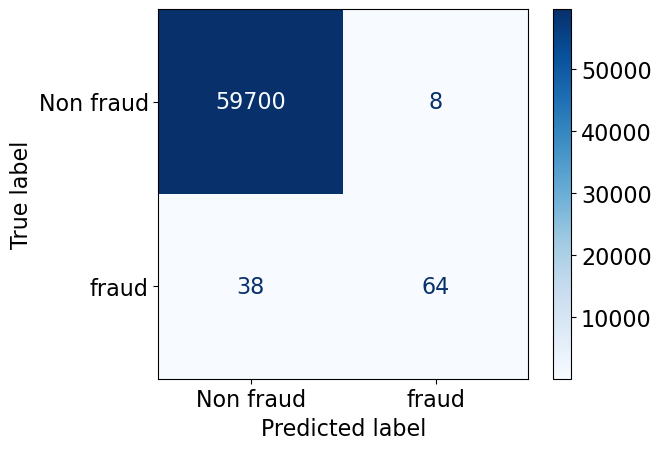

In [33]:
pipe_lr_weight = make_pipeline(
    StandardScaler(), LogisticRegression(max_iter=500)
)
ConfusionMatrixDisplay.from_estimator(
    pipe_lr,
    X_valid,
    y_valid,
    display_labels=["Non fraud", "fraud"],
    values_format="d",
    cmap=plt.cm.Blues,
);

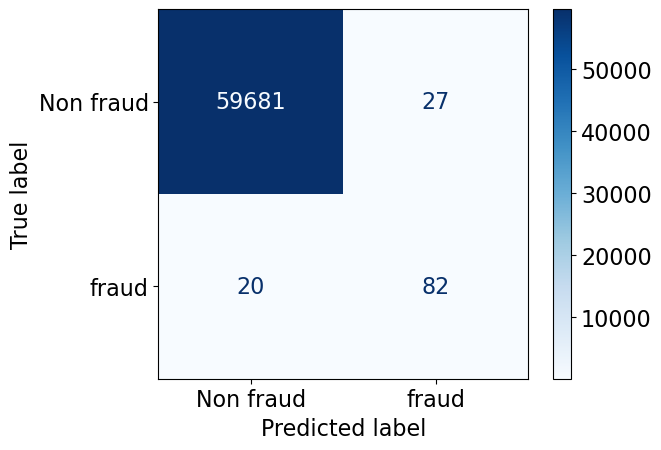

In [34]:
pipe_lr_weight = make_pipeline(
    StandardScaler(), LogisticRegression(max_iter=500, class_weight={0:1, 1: 10})
)
pipe_lr_weight.fit(X_train, y_train)
ConfusionMatrixDisplay.from_estimator(
    pipe_lr_weight,
    X_valid,
    y_valid,
    display_labels=["Non fraud", "fraud"],
    values_format="d",
    cmap=plt.cm.Blues,
);

### `class_weight="balanced"`
- A useful setting is `class_weight="balanced"`.
- This sets the weights so that the classes are "equal".

> class_weight: dict, ‘balanced’ or None
If ‘balanced’, class weights will be given by n_samples / (n_classes * np.bincount(y)). If a dictionary is given, keys are classes and values are corresponding class weights. If None is given, the class weights will be uniform.

> sklearn.utils.class_weight.compute_class_weight(class_weight, classes, y)

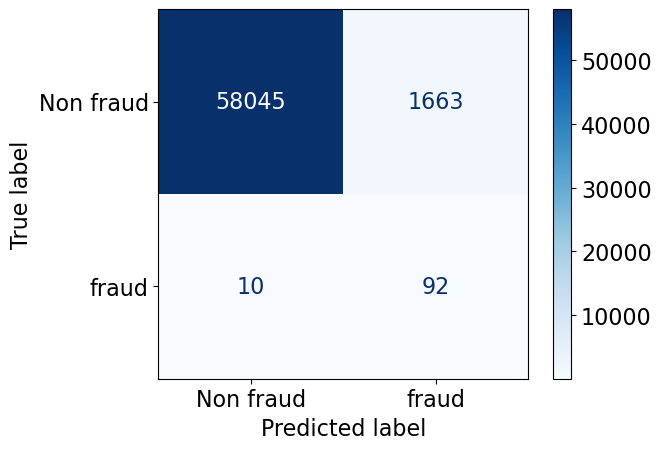

In [35]:
pipe_lr_balanced = make_pipeline(
    StandardScaler(), LogisticRegression(max_iter=500, class_weight="balanced")
)
pipe_lr_balanced.fit(X_train, y_train)
ConfusionMatrixDisplay.from_estimator(
    pipe_lr_balanced,
    X_valid,
    y_valid,
    display_labels=["Non fraud", "fraud"],
    values_format="d",
    cmap=plt.cm.Blues,
);

### Stratified Splits

- A similar idea of "balancing" classes can be applied to data splits.
- We have the same option in `train_test_split` with the `stratify` argument. 
- By default it splits the data so that if we have 10% negative examples in total, then each split will have 10% negative examples.

### Is stratifying a good idea? 

  - Well, it's no longer a random sample, which is probably theoretically bad, but not that big of a deal.
  - If you have many examples, it shouldn't matter as much.
  - It can be especially useful in multi-class, say if you have one class with very few cases.
  - In general, these are difficult questions.

## What did we learn today? 

- A number of possible ways to evaluate machine learning models 
    - Choose the evaluation metric that makes most sense in your context or which is most common in your discipline  
- Two kinds of binary classification problems 
    - Distinguishing between two classes (e.g., dogs vs. cats)
    - Spotting a class (e.g., spot fraud transaction, spot spam)

- Precision, recall, f1-score are useful when dealing with spotting problems. 
- The thing that we are interested in spotting is considered "positive".   
- Do you need to deal with class imbalance in the given problem? 
- Methods to deal with class imbalance 
    - Changing the training procedure 
        - `class_weight`